## Set up Google Colab environment

In [1]:
### Set colaboratory True to run in Google Colaboratory. 
colab = True

if colab:
  from google.colab import drive
  drive.mount('/content/drive')
  import os
  ## Specify a directory in Google Drive
  dir = '/content/drive/My Drive/Colab Notebooks/Keras_MNIST'
  os.chdir(dir)
  #os.getcwd()
  #os.listdir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
if colab:
  ## Check the uptime. (Google Colab reboots every 12 hours)
  !cat /proc/uptime | awk '{print "Uptime is " $1 /60 /60 " hours (" $1 " sec)"}'
  ## Check the GPU info
  !nvidia-smi
  ## Check the Python version
  !python --version

Uptime is 1.3406 hours (4826.16 sec)
Fri Jan 25 14:37:46 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    55W / 149W |    459MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                       

## Import modules

In [3]:
import os
import glob
import numpy as np
import pandas as pd
from IPython.display import display

import tensorflow as tf
from tensorflow import keras

tf.__version__

'1.12.0'

## Set up data

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

y_train = y_train[:1000]
y_test = y_test[:1000]

x_train = x_train[:1000].reshape(-1, 28 * 28) / 255.0
x_test = x_test[:1000].reshape(-1, 28 * 28) / 255.0

## Define model

In [0]:
# Returns a short sequential model
def create_model():
  model = tf.keras.models.Sequential([
    keras.layers.Dense(512, activation=tf.keras.activations.relu, input_shape=(784,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation=tf.keras.activations.softmax)
  ])
  
  model.compile(optimizer='adam', 
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'])
  return model

## Fit model

In [6]:
### If resume_if_possible = True, fitting can resume using a model file. 
resume_if_possible = True 

### Set resume_if_possible = False to force fitting from scratch.
#resume_if_possible = False 

epochs = 100
log_file_path = 'training_log.csv'
model_file_path = 'model_epoch{epoch:06d}.hdf5'

model_file_list = glob.glob('model_epoch*.hdf5')
log_file_list = glob.glob(log_file_path)

if resume_if_possible:
  resume_flag = (len(model_file_list) >= 1) 
  
if not resume_if_possible:
  resume_flag = False
  for f in model_file_list:
    os.remove(f)

if resume_flag:
  latest_model_file = model_file_list[-1]
  latest_epoch = int(latest_model_file[len('model_epoch'):-len('.hdf5')])
  ## Load the saved model
  model = keras.models.load_model(latest_model_file)

  score = model.evaluate(x_test,y_test, verbose=0)
  print('Use {} to resume fitting. \nTest loss: {}   Test accuracy: {}'.format(latest_model_file, score[0], score[1]))

  if len(model_file_list) >= 2:
    ## Delete all model files excpet the latest to save space
    for f in model_file_list[:-1]:
      os.remove(f)

if not resume_flag:
  latest_epoch = 0
  ## Create a basic model instance
  model = create_model()
  for f in log_file_list:
    os.remove(f)

model.summary()

## Create checkpoint callback
check_point_ = tf.keras.callbacks.ModelCheckpoint(filepath = model_file_path, 
                                                 monitor = 'val_acc',
                                                 verbose=1,
                                                 save_best_only = True,
                                                 mode='auto',
                                                 save_weights_only=False,
                                                 period = 1)

## Create early stopping callback
early_stopping_ = tf.keras.callbacks.EarlyStopping(monitor='val_acc', 
                                                   min_delta=0, 
                                                   patience=5, 
                                                   verbose=1, 
                                                   mode='auto', 
                                                   baseline=None)

## Create CSV logger callback
csv_logger_ = tf.keras.callbacks.CSVLogger(filename = log_file_path, separator=',',
                                           append = resume_flag)

## Fit 
model.fit(x_train, y_train, epochs = epochs, initial_epoch = latest_epoch,
          validation_data = (x_test,y_test), shuffle = True,
          callbacks = [check_point_, early_stopping_, csv_logger_])

## Remove duplicates as save_best_only option of checkpoint is set to True.
pd.options.display.max_rows = 8
log_df = pd.read_csv(log_file_path)
log_wo_dup_df = log_df.drop_duplicates(subset = ['epoch'], keep='last').reset_index(drop=True)
log_wo_dup_df.to_csv((log_file_path[:-len('.csv')] + '_processed.csv'), index=False)

Use model_epoch000005.hdf5 to resume fitting. 
Test loss: 0.4207589154243469   Test accuracy: 0.869
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 1000 samples
Epoch 6/100
 832/1000 [=======================>......] - ETA: 0s - loss: 0.1229 - acc: 0.9736
Epoch 00006: val_acc improved from -inf to 0.85800, saving model to model_epoch000006.hdf5
1000/1000 [==============================] - 0s 382us/step - loss: 

,epoch,acc,loss,val_acc,val_loss
0,0,0.650,1.226354,0.787,0.723651
1,1,0.870,0.446057,0.839,0.529928
2,2,0.930,0.285979,0.861,0.446682
3,3,0.949,0.196675,0.856,0.432636
...,...,...,...,...,...
17,17,1.000,0.010377,0.873,0.427959
18,18,1.000,0.008500,0.871,0.430861
19,19,1.000,0.008571,0.872,0.426044
20,20,1.000,0.008295,0.871,0.435119


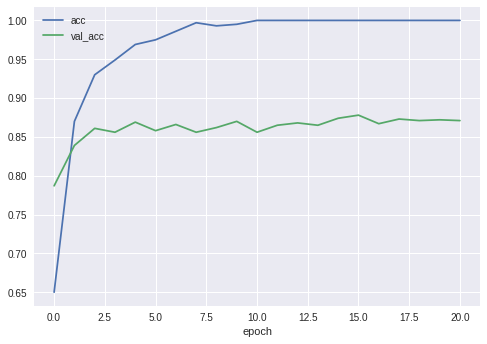

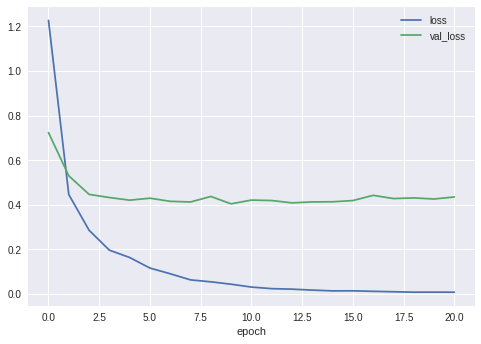

In [7]:
display(log_wo_dup_df)
log_wo_dup_df[['epoch', 'acc', 'val_acc']].plot(x='epoch')
log_wo_dup_df[['epoch', 'loss', 'val_loss']].plot(x='epoch')

References:


https://keras.io/callbacks/

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint